In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
6,047 cases (7 day average) as of Sat 12 Jun, +201.0 since Fri 11 Jun
166 hospitalised (7 day average) as of Tue 15 Jun, +5.9 since Mon 14 Jun
6 died (7 day average) as of Sat 12 Jun, +0.7 since Fri 11 Jun


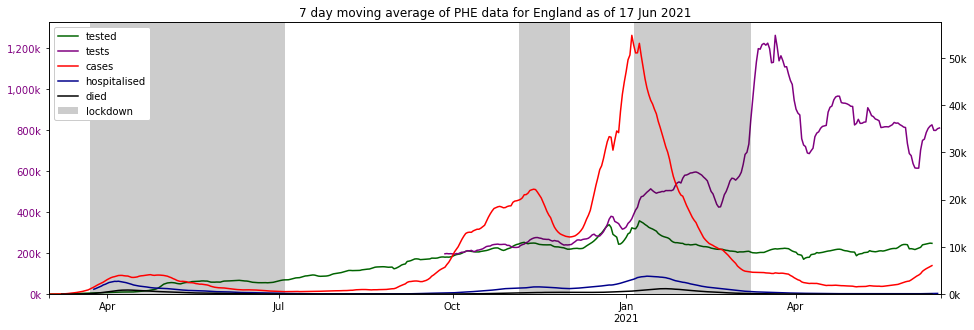

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

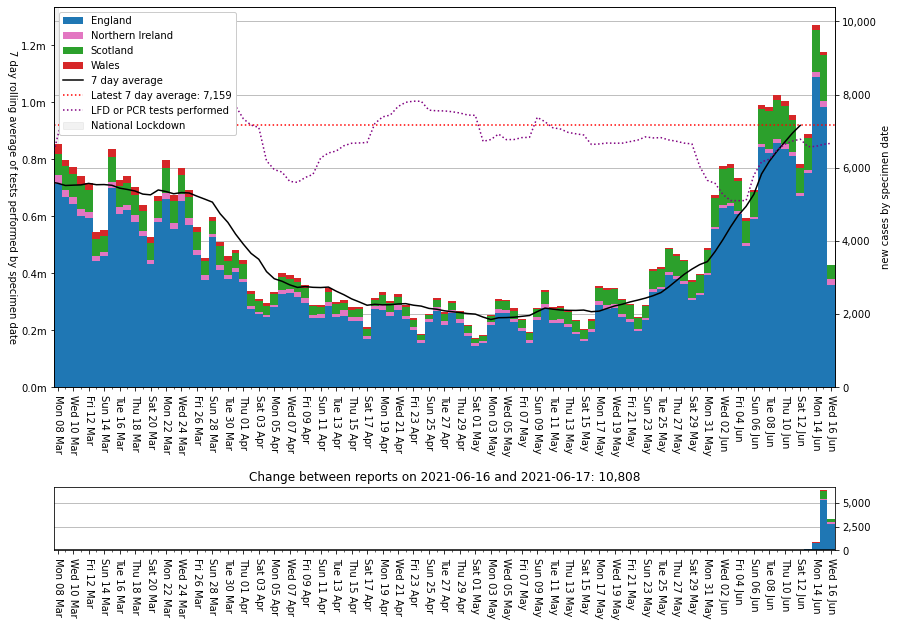

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

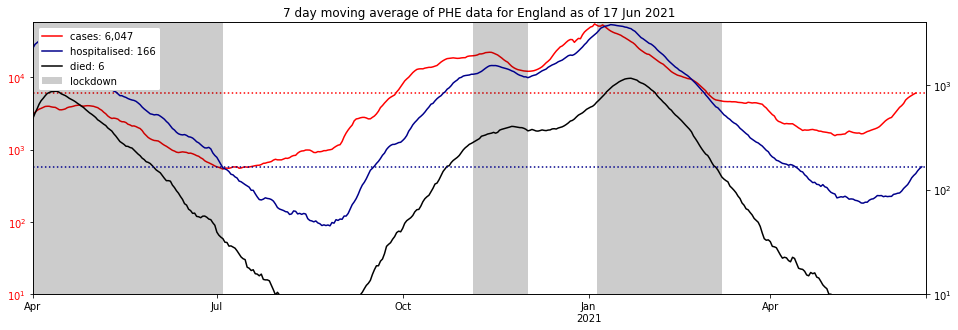

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

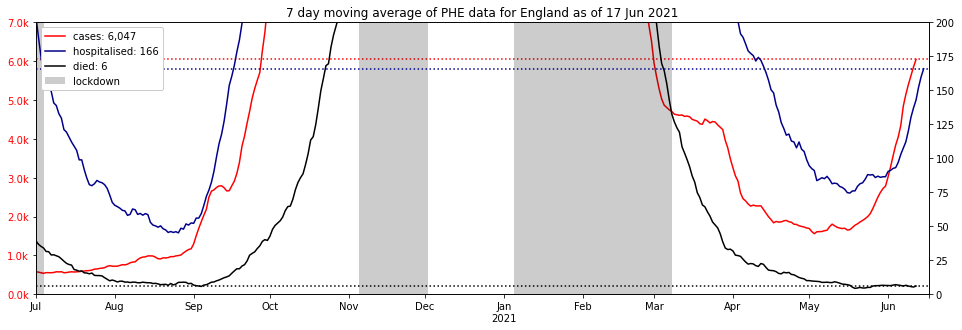

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=7_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=200)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,16 Jun 21,"+25,922,508","+35,290,759","+25,922,508","+180,627","+170,367","+180,627"
Northern Ireland,16 Jun 21,"+782,569","+1,128,670","+782,569","+9,636","+1,993","+9,636"
Scotland,16 Jun 21,"+2,516,066","+3,571,726","+2,516,066","+22,708","+19,987","+22,708"
Wales,16 Jun 21,"+1,454,064","+2,225,499","+1,454,064","+21,863","+3,218","+21,863"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,25922508.0,35290759.0,9368251.0,56286961,46.054197,16.643732,37.302071
1,Northern Ireland,N92000002,782569.0,1128670.0,346101.0,1893667,41.325587,18.276761,40.397652
2,Scotland,S92000003,2516066.0,3571726.0,1055660.0,5463300,46.053960,19.322754,34.623286
3,Wales,W92000004,1454064.0,2225499.0,771435.0,3152879,46.118611,24.467637,29.413752


'partial: 42,216,654 (63.2%), full: 30,675,207'

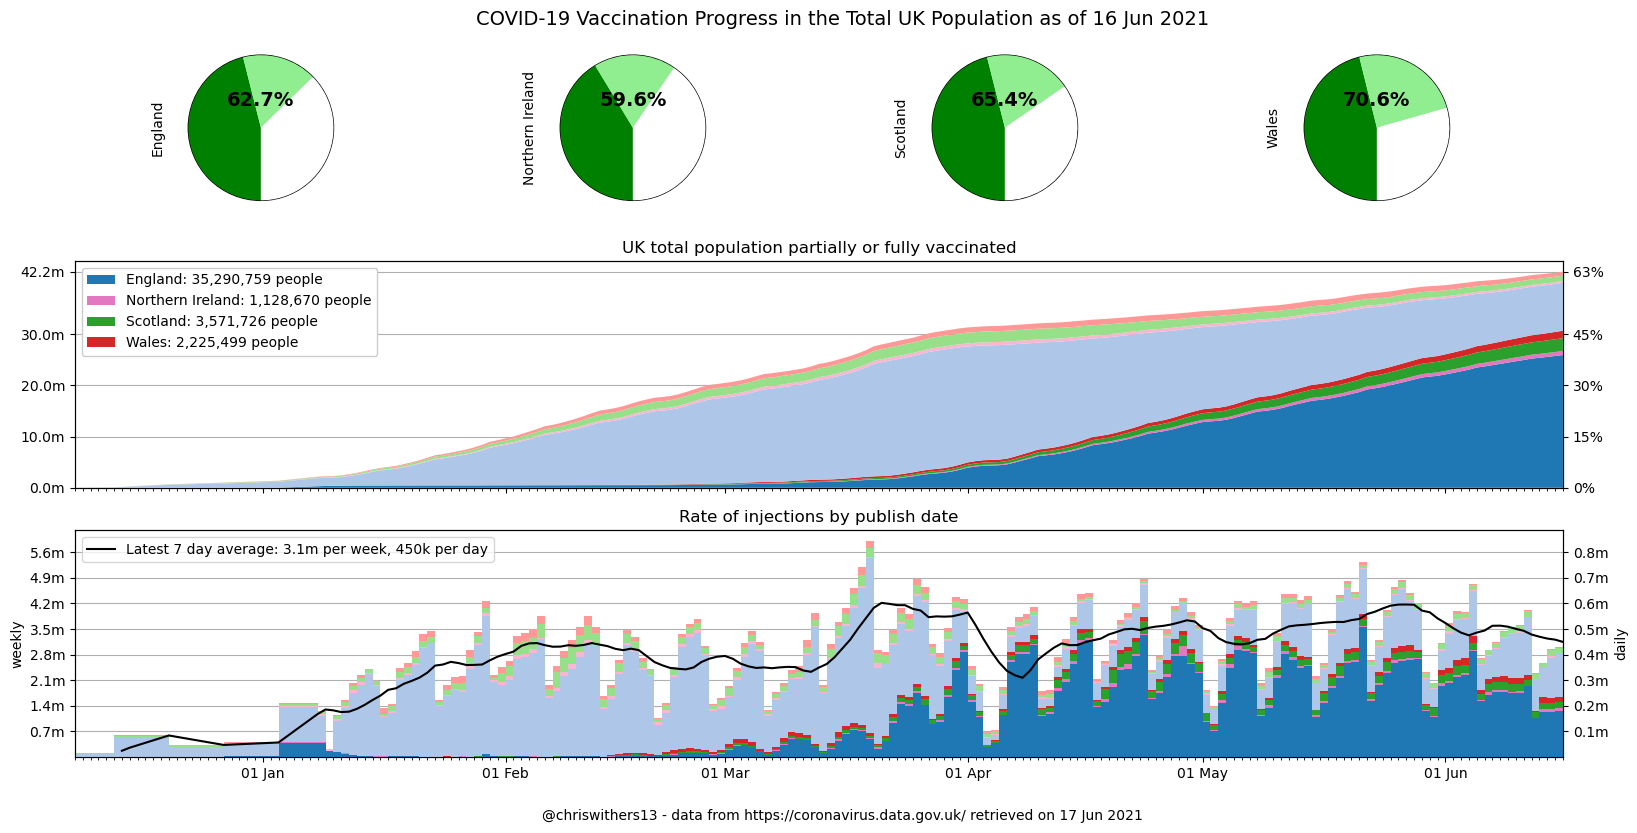

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

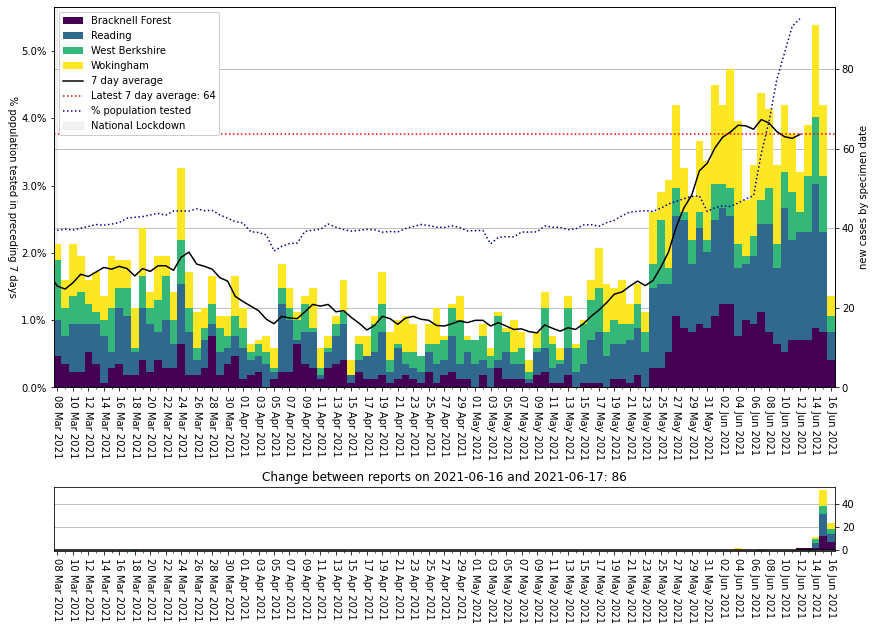

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

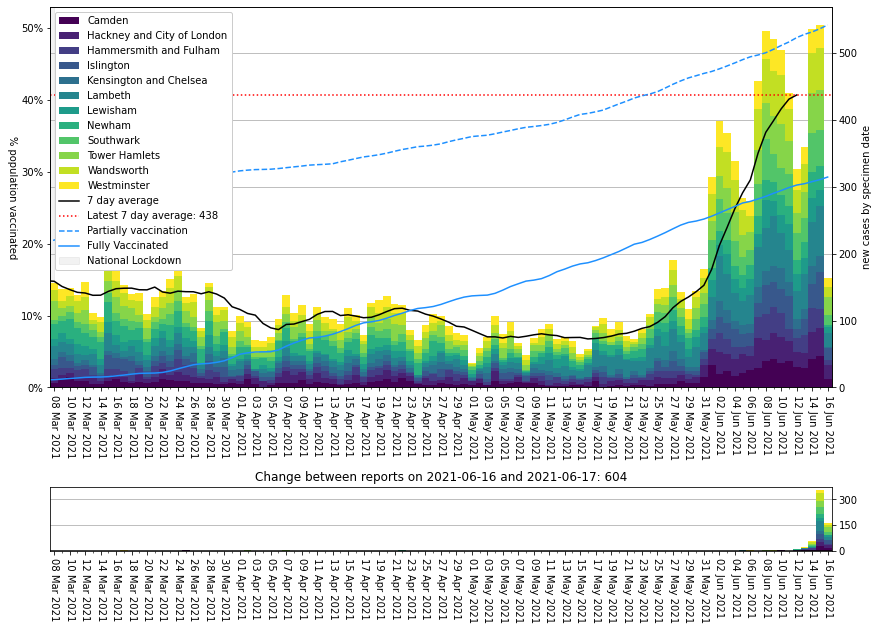

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,454.921975,681.0,2021-06-16
E07000120,Hyndburn,404.723418,328.0,2021-06-16
E07000124,Ribble Valley,369.530942,225.0,2021-06-16
E07000117,Burnley,354.251012,315.0,2021-06-16
E07000125,Rossendale,289.583392,207.0,2021-06-16
E08000003,Manchester,288.139088,1593.0,2021-06-16
E08000006,Salford,286.670221,742.0,2021-06-16
S12000042,Dundee City,284.623627,425.0,2021-06-16
E08000002,Bury,279.595790,534.0,2021-06-16


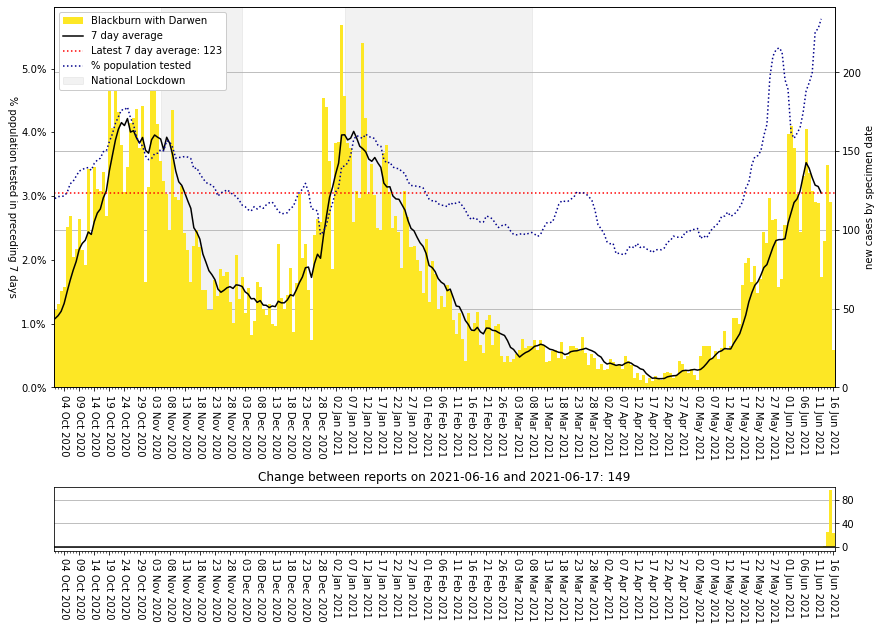

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,288.139088,1593.0,2021-06-16
E08000035,Leeds,170.588005,1353.0,2021-06-16
E08000025,Birmingham,98.965157,1130.0,2021-06-16
S12000036,City of Edinburgh,185.739051,975.0,2021-06-16
S12000049,Glasgow City,139.468031,883.0,2021-06-16
E08000010,Wigan,247.975123,815.0,2021-06-16
E08000012,Liverpool,158.621160,790.0,2021-06-16
E06000047,County Durham,143.936736,763.0,2021-06-16
E08000006,Salford,286.670221,742.0,2021-06-16


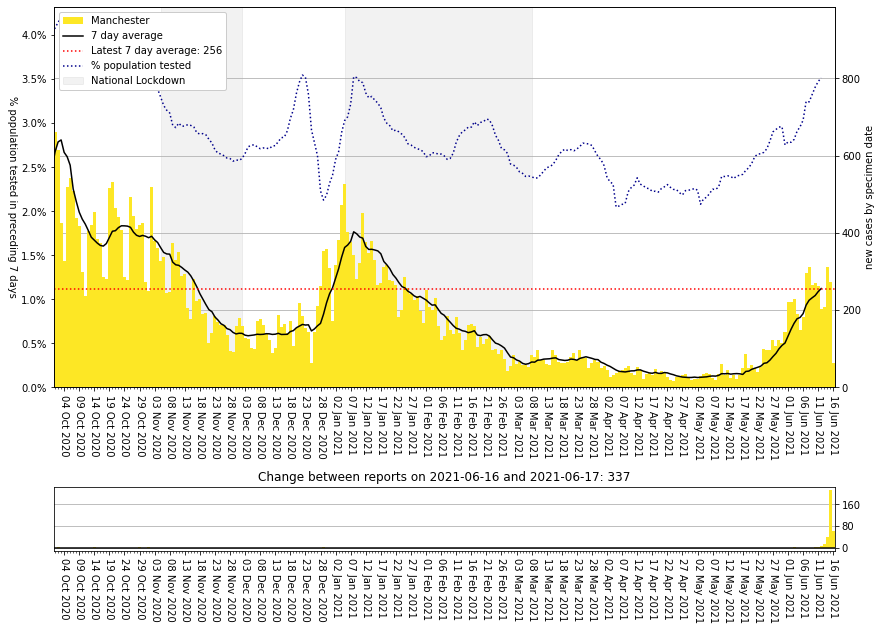

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

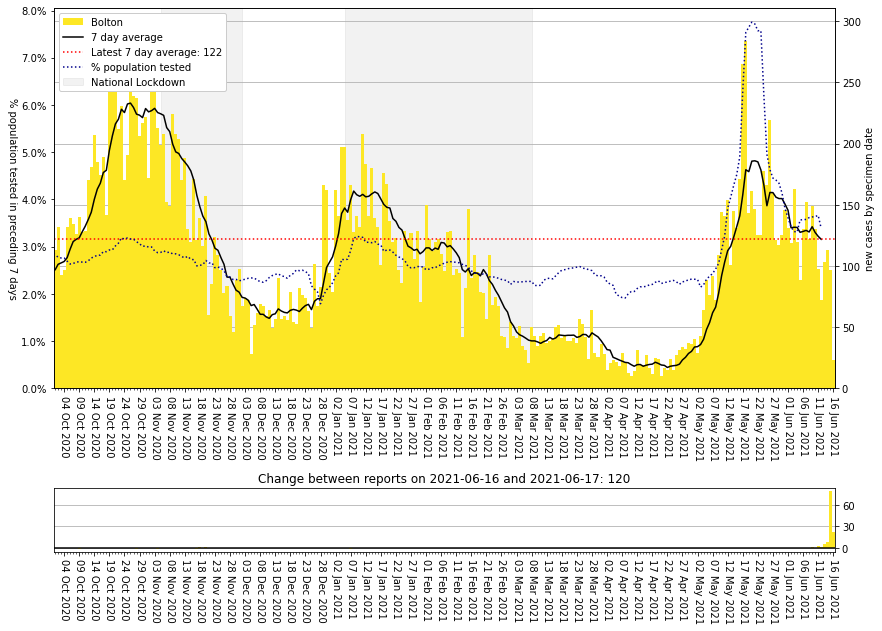

In [16]:
plot_areas(for_date, areas=['E08000001'], colormap='viridis_r', lines=unique_people_tested)

In [17]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.5

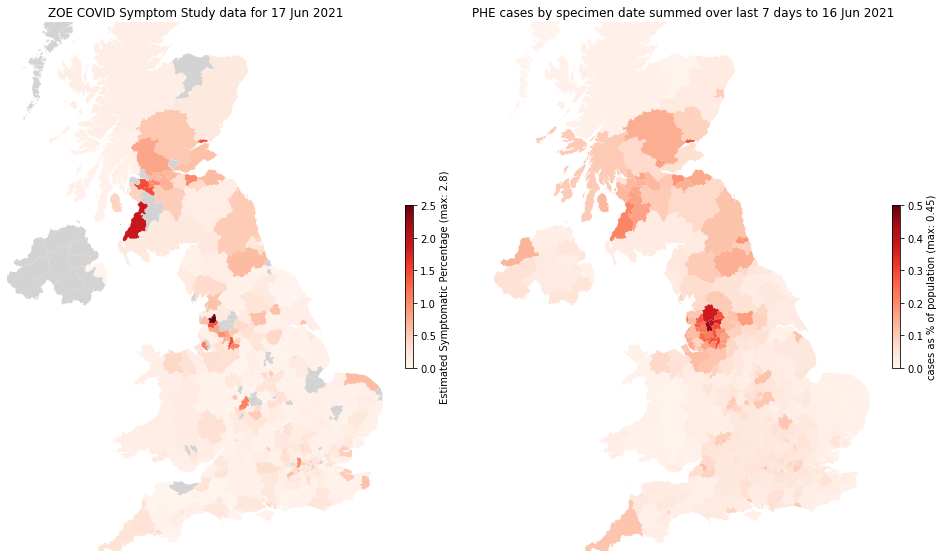

In [18]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [19]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...